In [1]:
"""
Demonstration of why static embeddings fail and BERT succeeds
"""

from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

sentences = [
    "He deposited money in the bank",
    "The fisherman sat on the bank of the river"
]

inputs = tokenizer(sentences, return_tensors="pt", padding=True)
outputs = model(**inputs)

# Extract embeddings for the word 'bank'
bank_token_id = tokenizer.convert_tokens_to_ids("bank")
embeddings = outputs.last_hidden_state

bank_embeddings = []
for i, sentence in enumerate(inputs["input_ids"]):
    idx = (sentence == bank_token_id).nonzero(as_tuple=True)[0]
    bank_embeddings.append(embeddings[i, idx].mean(dim=0))

cos_sim = torch.nn.functional.cosine_similarity(
    bank_embeddings[0], bank_embeddings[1], dim=0
)

print("Cosine similarity between 'bank' embeddings:", cos_sim.item())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Cosine similarity between 'bank' embeddings: 0.33295613527297974


In [4]:
from transformers.models.bert.modeling_bert import BertEmbeddings
from transformers import BertConfig
import torch

# Load BERT configuration
config = BertConfig()

# Initialize embedding layer
bert_embeddings = BertEmbeddings(config)

# Example input: [CLS] this is a test [SEP]
input_ids = torch.tensor([[101, 2023, 2003, 1037, 3231, 102]])
token_type_ids = torch.zeros_like(input_ids)

# Forward pass
embeddings = bert_embeddings(
    input_ids=input_ids,
    token_type_ids=token_type_ids
)

print("Embedding tensor shape:", embeddings.shape)


Embedding tensor shape: torch.Size([1, 6, 768])


In [7]:
import random

def apply_bert_masking(tokens, tokenizer):
    masked_tokens = tokens.copy()
    labels = [-100] * len(tokens)

    for i in range(len(tokens)):
        if random.random() < 0.15:
            labels[i] = tokens[i]
            prob = random.random()

            if prob < 0.8:
                masked_tokens[i] = tokenizer.mask_token_id
            elif prob < 0.9:
                masked_tokens[i] = random.randint(0, tokenizer.vocab_size - 1)
            else:
                pass  # keep original

    return masked_tokens, labels


In [8]:
"""
Stage 1: Base BERT (General English)
Stage 2: Domain-Adaptive Pretraining (TRC2 Financial News)
Stage 3: Task-Specific Fine-Tuning (Financial PhraseBank)
"""

class FinBERTPipeline:
    def __init__(self):
        self.stage1 = "bert-base-uncased"
        self.stage2 = "Domain Adaptive Pretraining"
        self.stage3 = "Sentiment Fine-tuning"

    def describe(self):
        return {
            "Stage 1": self.stage1,
            "Stage 2": "Pretrain on Financial News (MLM)",
            "Stage 3": "Fine-tune on labeled sentiment data"
        }

pipeline = FinBERTPipeline()
pipeline.describe()


{'Stage 1': 'bert-base-uncased',
 'Stage 2': 'Pretrain on Financial News (MLM)',
 'Stage 3': 'Fine-tune on labeled sentiment data'}

In [9]:
"""
Domain Adaptation via continued MLM pretraining
"""

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./finbert-domain-adapt",
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    num_train_epochs=2,
    save_steps=10_000,
    save_total_limit=2,
)

# Trainer would be initialized with TRC2 dataset


In [11]:
dataset_usage = {
    "TRC2_Financial": "Large unlabeled corpus → language understanding",
    "Financial_PhraseBank": "Small labeled dataset → sentiment classification"
}

dataset_usage


{'TRC2_Financial': 'Large unlabeled corpus → language understanding',
 'Financial_PhraseBank': 'Small labeled dataset → sentiment classification'}

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

MODEL_NAME = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
import torch
import numpy as np

MAX_LEN = 512

def chunk_text(text, tokenizer, max_len=512):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    return [tokens[i:i+max_len] for i in range(0, len(tokens), max_len)]

def predict_sentiment_long_doc(text):
    chunks = chunk_text(text, tokenizer)
    probs_list = []

    for chunk in chunks:
        input_ids = torch.tensor([[tokenizer.cls_token_id] + chunk + [tokenizer.sep_token_id]])
        attention_mask = torch.ones_like(input_ids)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=-1)

        probs_list.append(probs.numpy())

    avg_probs = np.mean(probs_list, axis=0)
    sentiment = ["negative", "neutral", "positive"][np.argmax(avg_probs)]

    return {
        "sentiment": sentiment,
        "confidence": avg_probs.tolist()
    }


In [16]:
news = """
The company reported strong quarterly earnings beating market expectations.
However, rising inflation and interest rate uncertainty remain concerns.
"""

predict_sentiment_long_doc(news)


{'sentiment': 'negative',
 'confidence': [[0.8270506262779236, 0.13719584047794342, 0.0357535183429718]]}

In [ ]:
#let's check for tesla


In [17]:
!pip install transformers torch matplotlib numpy


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [19]:
MODEL_NAME = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
tesla_news = """
New Street Research raised its price target to a street-high $600 (up from $520),
suggesting nearly 38.6% upside potential from recent levels.

This rally follows a broader surge in 2024, where Tesla’s stock rose roughly 71%,
with most gains occurring after Donald Trump’s election.

Tesla reported Q4 vehicle deliveries of 418,000, which fell short of expectations,
leading HSBC to maintain a 'Reduce' rating on the stock.
"""


In [21]:
MAX_LEN = 512

def chunk_text(text, tokenizer, max_len=512):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    return [tokens[i:i+max_len] for i in range(0, len(tokens), max_len)]


In [25]:
def predict_sentiment_long_doc(text):
    chunks = chunk_text(text, tokenizer)
    all_probs = []

    for chunk in chunks:
        input_ids = torch.tensor(
            [[tokenizer.cls_token_id] + chunk + [tokenizer.sep_token_id]]
        )
        attention_mask = torch.ones_like(input_ids)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = F.softmax(outputs.logits, dim=-1)

        all_probs.append(probs.numpy()[0])

    avg_probs = np.mean(all_probs, axis=0)
    labels = ["Negative", "Neutral", "Positive"]

    return labels, avg_probs




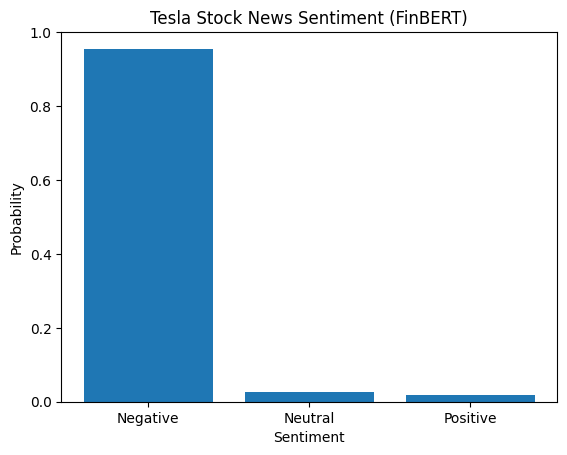

In [26]:
labels, probs = predict_sentiment_long_doc(tesla_news)
labels, probs
plt.figure()
plt.bar(labels, probs)
plt.title("Tesla Stock News Sentiment (FinBERT)")
plt.xlabel("Sentiment")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()

